In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning


from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

import warnings

import seaborn as sns




In [410]:
data_t = pd.read_csv('prison_2010.txt', delimiter='\t', skiprows=2)
data_t = data_t.drop(range(53,58))

for col in data_t.columns:
   if not (data_t[col].apply(lambda x: isinstance(x, str))).all():
       continue
   
   if (data_t[col].apply(lambda x: isinstance(x, str)).all() & data_t[col].str.contains(',')).any():
        try:
            data_t[col] = data_t[col].replace('[\$,]', '', regex=True).astype(float)
        except AttributeError as err:
            print([col])
            break   
data_t = data_t.iloc[1:, :]

In [411]:
def processData(data, flag=False):
    df = data.iloc[:, 2:]
    # Create a boolean mask of NaN values
    nan_mask = df.isnull()

    # Check for any NaN values in each row
    nan_in_row = nan_mask.any(axis=1)

    # Check for any NaN values in each column
    nan_in_col = nan_mask.any(axis=0)
    rows_with_nans = df[nan_in_row]
    cols_with_nans = df.loc[:, nan_in_col]
    if flag:
        print("Features Containing NaN:", cols_with_nans)
    
    # Drop columns with NaN values and filter out columns containing "Population"
    df = df.drop(columns=cols_with_nans).filter(regex='^(?!.*(Population)).*')
    
    # Standardize the numerical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
    df[df_std.columns] = df_std
    
    return df

def getX(df):
       X = df.iloc[:, 2:]
       return X

def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data


def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
    fig = px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
    fig.show()

def stateClusterGraph(cluster_data):
    state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }
    cluster_data['State Abbreviation'] = cluster_data['Geography'].map(state_abbreviations)


    # Create a choropleth map
    fig = px.choropleth(cluster_data, locations='State Abbreviation', locationmode='USA-states', color='Cluster', scope='usa', title='Clusters by State')

    # fig.show()
    return fig


def elbow_method(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df.iloc[:,1:6]

    # Perform K-means clustering for different values of K
    inertias = []
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, init = 'k-means++' , random_state=42, n_init=10).fit(X)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    # Plot the elbow curve to choose the optimal value of K
    plt.plot(range(1, n), inertias, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

    # create dataframe for elbow plot data
    elbow_data = pd.DataFrame({
        'K': range(1, n),
        'Inertia': inertias
    })
    elbow_data = elbow_data.set_index('K')

    # print(elbow_data)

    # Calculate the slope and second derivative of the inertia curve
    slopes = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    second_derivatives = [slopes[i+1] - slopes[i] for i in range(len(slopes)-1)]

    # Find the index of the maximum second derivative
    max_index = second_derivatives.index(max(second_derivatives))

    # The optimal value of K is one more than the index of the maximum second derivative
    best_k = max_index + 2
    # print(best_k)

    # return df, elbow_data, inertias, best_k


def correlationMap(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculate the correlation matrix
    corr_matrix = numeric_columns.corr()
    
    # Set the upper triangle to NaN
    corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
    np.fill_diagonal(corr_matrix.values, np.nan)

    
    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation of Numeric Features')
    plt.show()


In [412]:
processData(data_t)

,Geography,Total : In Correctional Facilities for Adults,White alone : in Correctional Facilities for Adults,Black or African American alone : in Correctional Facilities for Adults,American Indian and Alaska Native alone : in Correctional Facilities for Adults,Asian alone : in Correctional Facilities for Adults,Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,Some other race alone : in Correctional Facilities for Adults,Two or more races : in Correctional Facilities for Adults,Hispanic or Latino : in Correctional Facilities for Adults,...,Female incarceration rate,Female incarceration rate: White alone,Female incarceration rate: Black or African American alone,Female incarceration rate: American Indian and Alaska Native alone,Female incarceration rate: Asian alone,Female incarceration rate: Native Hawaiian and other Pacific Islander alone,Female incarceration rate: Some other race alone,Female incarceration rate: Two or more races,Female incarceration rate: Hispanic or Latino,"Female incarceration rate: White alone, not Hispanic or Latino"
1,Alabama,-0.046607,-0.142180,0.242536,-0.567108,-0.394687,-0.297112,-0.338043,-0.266801,-0.359694,...,1.452992,1.683750,-0.404747,-0.921355,-0.290556,-0.368844,-0.244581,1.623662,1.287841,1.438526
2,Alaska,-0.730722,-0.728050,-0.808617,0.717104,-0.413876,-0.175232,-0.372633,-0.132105,-0.421320,...,0.855357,0.265390,-0.553864,0.458064,-0.870181,-0.214631,-0.250028,2.764198,0.467418,0.079857
3,Arizona,0.432925,0.493162,-0.433127,5.182977,1.189169,2.680262,1.359909,2.033800,0.989995,...,1.362441,1.070405,0.578717,0.632520,2.105230,-0.329715,0.991837,0.991744,0.609074,0.807032
4,Arkansas,-0.329800,-0.295128,-0.301858,-0.491000,-0.309073,-0.276799,-0.301128,-0.408680,-0.345101,...,0.619925,0.802066,-0.401196,-0.170789,0.173145,-0.368844,-0.326283,0.513952,-0.353004,0.807032
5,California,3.942558,3.880568,2.511116,2.521824,6.283193,2.273992,5.696049,5.345515,5.121527,...,-0.213143,0.016218,0.280482,-0.061247,-0.367839,-0.113358,-0.026710,-0.287505,-0.217251,-0.188050
6,Colorado,-0.057258,0.237743,-0.471527,0.800210,0.083570,-0.163624,-0.127081,0.324064,0.261083,...,0.293942,0.457060,0.631973,0.839432,0.327711,0.031648,-0.113859,0.066986,0.414297,-0.092369
7,Connecticut,-0.435323,-0.536433,-0.431118,-0.561860,-0.294312,-0.163624,0.204197,-0.329659,-0.133714,...,0.221501,-0.367122,0.166869,0.559492,1.564246,0.793503,1.449366,1.469536,1.116673,-0.723863
8,Delaware,-0.687509,-0.701335,-0.639618,-0.631844,-0.467016,-0.294210,-0.370309,-0.744521,-0.424627,...,-0.720227,-0.692962,-0.727834,-1.128268,-0.483764,1.746397,-0.527813,-0.934836,-0.825190,-0.628182
9,District of Columbia,-0.740651,-0.784974,-0.673284,-0.618722,-0.446350,-0.302916,-0.363063,-0.602642,-0.419168,...,0.275832,-1.363808,-0.518360,-0.552158,0.018578,-0.532263,-0.375304,2.132279,-0.282176,-1.546719
10,Florida,2.272557,2.295312,2.806172,-0.268800,0.180993,-0.201349,-0.048602,1.561467,0.746324,...,0.674255,0.629563,-0.142016,-0.604900,-0.329198,-0.338922,-0.162880,-0.179617,-0.358906,0.979257


/var/folders/yn/4nkcf4bx0tl9zps6_x1krghm0000gn/T/ipykernel_46979/3387723368.py:155: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



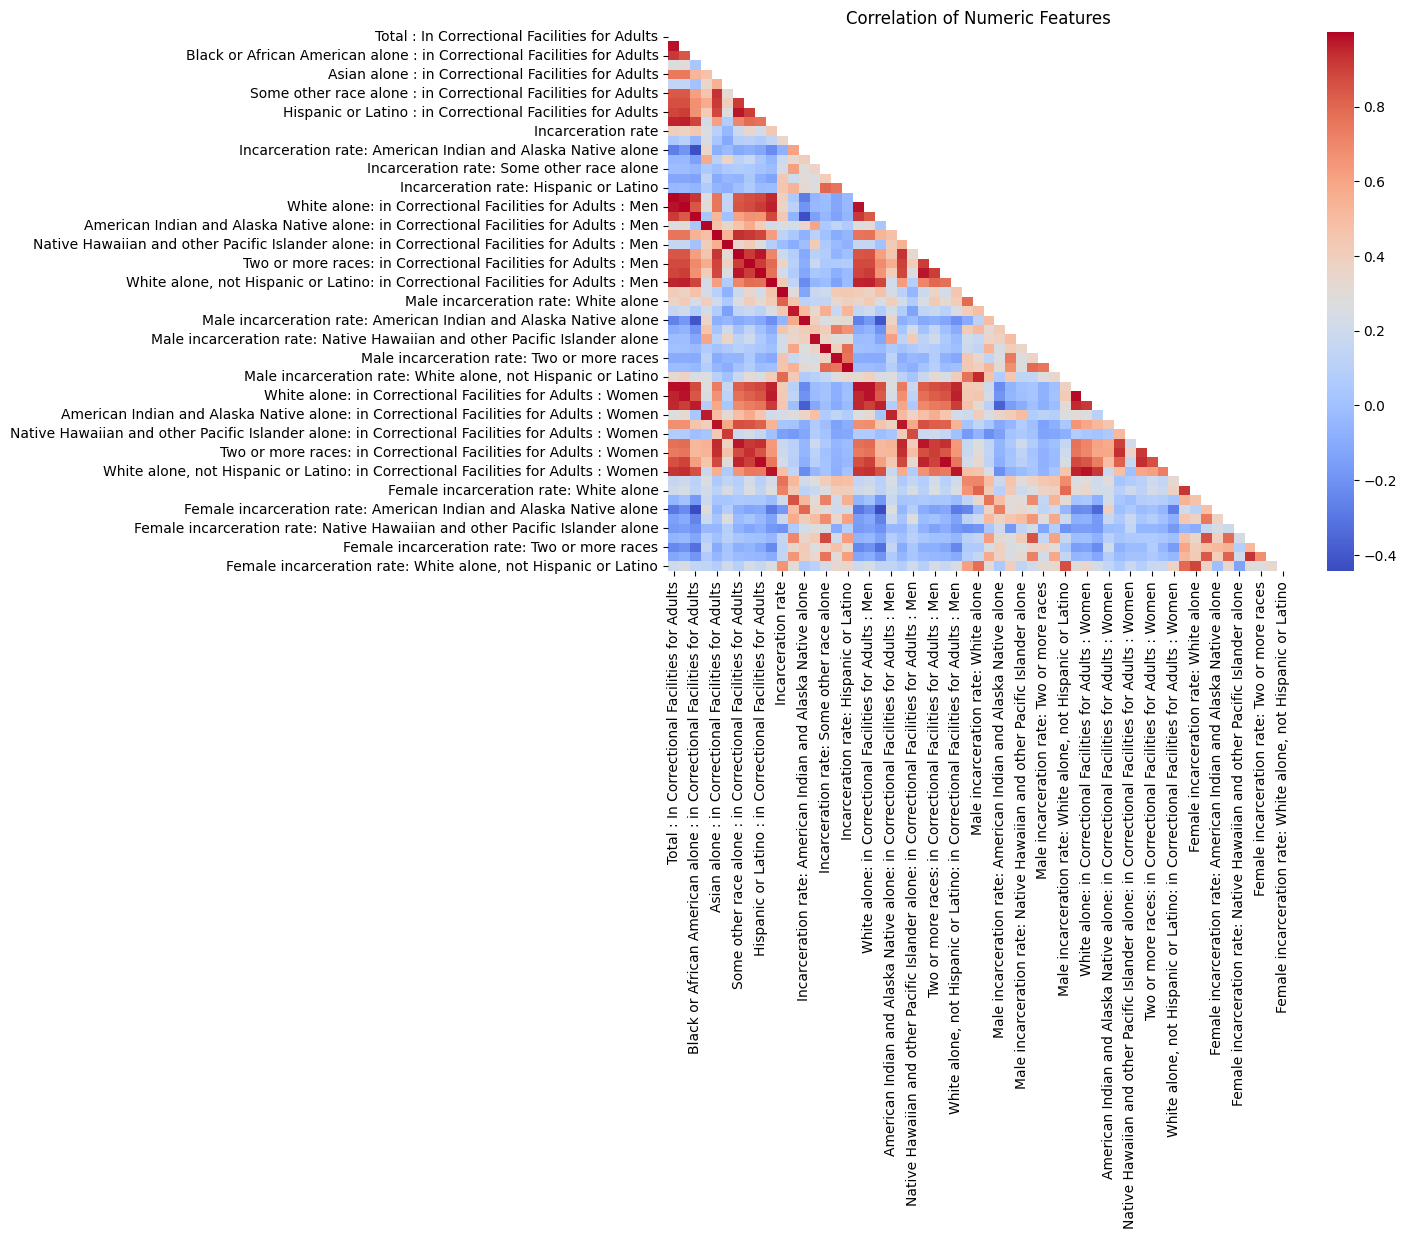

In [413]:
correlationMap(processData(data_t))

In [414]:
# Data frames that onyl consider Incarceration rates
rate_df_whole =processData(data_t).filter(regex='^(?!.*(Correctional)).*') 
rate_df_total = rate_df_whole.filter(regex='^(?!.*([Mm]ale)).*') # Total rates
rate_df_male = rate_df_whole.filter(regex='.*(Geography|Male).*') # Male rates
rate_df_female = rate_df_whole.filter(regex='.*(Geography|[Fem]ale).*') # Female rates



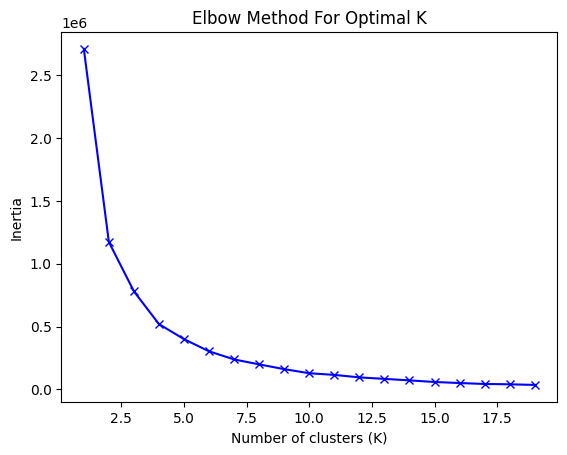

In [415]:
elbow_method(rate_df_whole, 20) ## Used to determine best k for K-means

In [416]:
n=4

In [417]:
# Get graphs with State abbrevations assigned for each
total_rate_fig = stateClusterGraph(runKmeans(rate_df_total, getX(rate_df_total), n)) 
male_rate_fig= stateClusterGraph(runKmeans(rate_df_male, getX(rate_df_male), n))
female_rate_fig = stateClusterGraph(runKmeans(rate_df_female, getX(rate_df_female), n))

In [418]:
# Make 3 subplots for 
# Create a 1x3 grid of subplots with titles and a geo subplot type
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]]
)

# Add your figures as subplots
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Update the geo attribute of each subplot to set the scope to 'usa'
fig.update_geos(scope='usa')

# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [419]:
full  = processData(data_t)
stateClusterGraph(runKmeans(full, getX(full), n))

In [420]:
createBarChart(runKmeans(full, getX(full), n), x_axis="Geography", y_axis='Total : In Correctional Facilities for Adults')
